In [1]:
using Plots
using LinearAlgebra
using Statistics
include("src/Trajectories.jl")
using .QuTaM

In [21]:
using DifferentialEquations
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [2]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=2000)
multiplier=1.0
tf=25.0
dt=0.0003333333333333333
eps=0.001)

In [4]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [22]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [5]:
# Steady State
gamma = QuTaM.rf_gamma
delta = QuTaM.rf_delta
omega = QuTaM.rf_omega
#r_steady = 1/(gamma^2 + 2*omega^2+4*delta^2) * [-4*delta*omega; 2*omega*gamma;-gamma^2-4*delta^2 ]

0.5

In [6]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
@time begin
    
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

end 

  6.448975 seconds (39.39 M allocations: 3.485 GiB, 9.40% gc time, 0.32% compilation time)


In [7]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  8.620065 seconds (77.54 M allocations: 2.857 GiB, 2.47% gc time, 1.21% compilation time)


In [8]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.049093 seconds (58.13 k allocations: 1.957 MiB, 94.94% compilation time)


In [9]:
import Distributions
using HypothesisTests
using QuadGK
using Random

struct WTD_rf <: Distributions.ContinuousUnivariateDistribution
    omega::Float64
    gamma::Float64
    
end


function Distributions.support(d::WTD_rf)
    return Distributions.Interval(0, Inf)
end

function Distributions.pdf(d::WTD_rf, tau::Real)
        # Replace with your custom formula
        gamma = d.gamma
        omega = d.omega
        return (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    end

function Distributions.cdf(d::WTD_rf, t::Real)
    pdf(tau) = (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    return quadgk(pdf, 0, t, rtol=1e-8)[1]
end 


function Base.rand(rng::AbstractRNG, d::WTD_rf)
    # Use inversion sampling
    alpha = rand() 
    t = 0
    dt = 0.001 # This is a magic number, the point is that this matches the dt in rf_params
    while Distributions.cdf(d, t) < alpha 
        t = dt + t
    end 
    return t  # Return a sample
end

In [10]:
f = WTD_rf(gamma, omega)

WTD_rf(omega=0.5, gamma=0.5)

In [19]:
f_sample = rand(f, 500)

500-element Vector{Float64}:
  8.404000000000782
  3.6019999999997143
 13.958999999997703
  3.6979999999997037
  0.9280000000000007
  2.9999999999997806
  4.0659999999996925
  4.060999999999691
  9.105000000000393
  4.95699999999999
  2.1189999999998776
  9.853999999999978
  2.6759999999998163
  ⋮
  3.1029999999997693
  1.7629999999999166
  0.4840000000000004
  1.007
  4.462999999999825
  8.978000000000463
  5.170000000000061
  4.5179999999998435
  1.18799999999998
  9.098000000000397
 10.451999999999646
  3.4179999999997346

In [20]:
HypothesisTests.ApproximateTwoSampleKSTest(tau_sample, f_sample)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0400298

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.4234

Details:
    number of observations:   [12961,500]
    KS-statistic:              0.8783120003603424


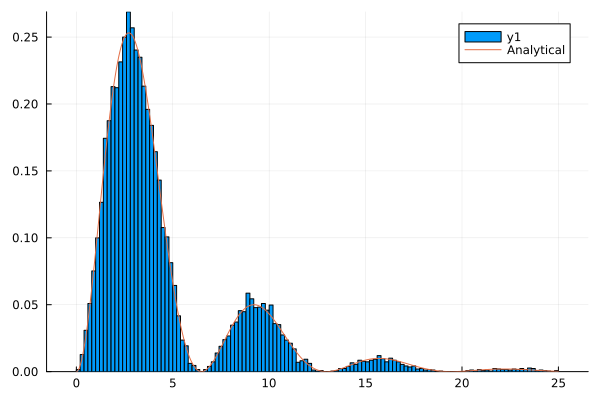

In [11]:
WTD_analytical(tau) =  (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
histogram(tau_sample, normalize=:pdf)
plot!(t_given, Distributions.pdf.(f, t_given), label="Analytical")

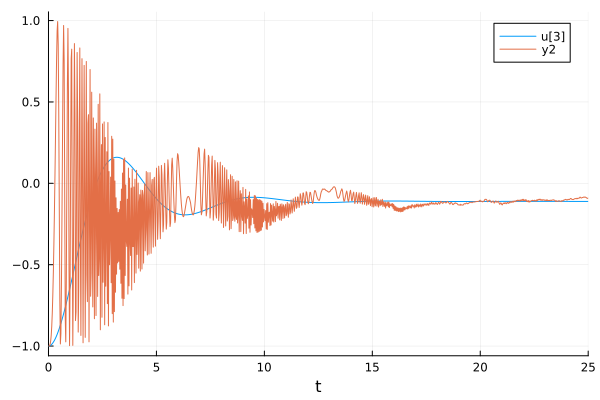

In [24]:
plot(sol, idxs=(0,3))
plot!(t_given, r_avg[:, 3])